# FFT

In [22]:
%%writefile FFT.py
from scipy.fft import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.special

def FFT(y,x=None,opts=None):
    
    if opts is None:
        opts = {}
    if "xmin" not in opts:
        opts["xmin"] = 0.
    if "xmax" not in opts:
        opts["xmax"] = 1.
    if "plot" not in opts:
        opts["plot"] = False
    if "fig" not in opts:
        opts["fig"] = None
    if "ax0" not in opts or "ax1" not in opts:
        opts["ax0"] = 121
        opts["ax1"] = 122
    if "inv" not in opts:
        opts["inv"] = False
    if "norm" not in opts:
        opts["norm"] = "ortho"
    
    y = np.asarray(y)
    N = len(y)
    
    if opts["inv"] == False :
        yf = fft(y,norm=opts["norm"])
        xf = fftshift(fftfreq(N)*N).astype(int)
        yplot = fftshift(yf)   
    else :
        yf = fftshift(y)   
        yplot = ifft(yf,norm=opts["norm"])
        xf = fftshift(fftfreq(N)*N).astype(int)
        
     
    out = pd.DataFrame(data=yplot,index=xf,columns=["fft"],dtype=np.complex)
    
    if opts["plot"] == True:
        
        if x is None:
            x = np.linspace(opts["xmin"],opts["xmax"] , N, endpoint=False)
        #
        if opts["fig"] is None:
            fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )
        else :
            fig = opts["fig"]
            
        if opts["inv"] == False:
            x1 = x
            x2 = xf
            title1 = "Original Function"
            title2 = "Fourier Transform"
        else :
            x1 = xf
            x2 = x
            title1 = "Fourier Transform"
            title2 = "Original Function (Anti-Trasform)"

        #
        ax = fig.add_subplot(opts["ax0"])
        plt.plot(x1, y.real,color="blue" ,label="real")#,marker="+")
        plt.plot(x1, y.imag,color="green",label="imag")#,marker="x")
        #plt.xlim(min(x),max(x))
        plt.legend()
        plt.grid(True)
        plt.title(title1)

        #
        ax = fig.add_subplot(opts["ax1"])
        plt.plot(x2, yplot.real,color="blue" ,label="real")#,marker="+")
        plt.plot(x2, yplot.imag,color="green",label="imag")#,marker="x")
        #plt.xlim(min(xf),max(xf))
        plt.legend()
        plt.grid(True)
        plt.title(title2)
        
        plt.show()

    return out


Overwriting FFT.py


In [23]:
%%writefile -a FFT.py
def analytic_solution_circle(uinc,XY,wmin,wmax,radius,wavevector,x=None,opts=None):
    
    if opts is None:
        opts = {}
    if "return" not in opts:
        opts["return"] = "np"
    #if "norm" not in opts:
    #opts["norm"] = None
    
    fft = FFT(uinc,opts=opts)
    NN = np.sqrt(len(fft))
    
    # converto un punto in 2D in un numero complesso
    z = np.asarray([ np.complex(i[0],i[1]) for i in XY ])
    r = np.absolute(z)
    theta = np.angle(z)
    
    # considero solo un range di frequenze 
    # perché scipy.special.hankel1 mi da problemi per alte frequenze    
    Z = np.arange(wmin,wmax+1)#fft.index
    coeff = np.zeros(shape=(len(r),len(Z)),dtype=np.complex)
    
    #
    rw = radius*wavevector
    #
    for i in range(len(z)):
        for j in range(len(Z)):
            a = fft.at[Z[j],"fft"]/NN
            b = scipy.special.hankel1(Z[j],r[i]*wavevector)
            c = scipy.special.hankel1(Z[j],rw)
            d = np.exp(1.j*Z[j]*theta[i])
            coeff[i,j] = - a*b*d/c
    
    analytic = coeff.sum(axis=1)
    index = [tuple(i) for i in XY]
    out = pd.DataFrame(index=index,columns=["xy","r","theta","value"],dtype=object)
    out["xy"] = [ i  for i in XY]
    out["r"] = r   
    out["theta"] = theta   
    out["value"] = analytic   

    if opts["return"] == "both":
        return out,analytic
    elif opts["return"] == "pd":
        return out
    elif opts["return"] == "np":
        return analytic
    else :
        print("error: return must be \"both\",\"pd\" or \"np\"")
        return None
    

Appending to FFT.py


In [4]:
%%writefile -a FFT.py
def analytic_solution_circle_0(uinc,XY,wmin,wmax,radius,wavevector,x=None,opts=None):
    
    if opts is None:
        opts = {}
    if "return" not in opts:
        opts["return"] = "np"
    
    fft = FFT(uinc,opts=opts)
    
    # converto un punto in 2D in un numero complesso
    z = np.asarray([ np.complex(i[0],i[0]) for i in XY ])
    r = np.absolute(z)
    theta = np.angle(z)
    
    # considero solo un range di frequenze 
    # perché scipy.special.hankel1 mi da problemi per alte frequenze    
    Z = np.arange(wmin,wmax+1)#fft.index
    coeff = np.zeros(shape=(len(r),len(Z)),dtype=np.complex)
    
    #devo normalizzare i coefficienti
    norm = np.sqrt(len(uinc))
    den  =  np.asarray([ fft.loc[ i ]/( scipy.special.hankel1(i,radius*wavevector) * norm ) for i in Z ])
    den = den.reshape((len(den),))
    
    #
    expo = np.exp(1.j*np.outer(theta,Z))

    for i in range(len(r)) : 
        coeff[i,:] = np.multiply(den,scipy.special.hankel1(Z,r[i]*wavevector))

    analytic = - np.multiply(coeff,expo).sum(axis=1)
    index = [tuple(i) for i in XY]
    out = pd.DataFrame(index=index,columns=["xy","value"],dtype=object)
    out["xy"] = [ i  for i in XY]
    out["value"] = analytic    
    if opts["return"] == "both":
        return out,analytic
    elif opts["return"] == "pd":
        return out
    elif opts["return"] == "np":
        return analytic
    else :
        print("error: return must be \"both\",\"pd\" or \"np\"")
        return None
    

Appending to FFT.py


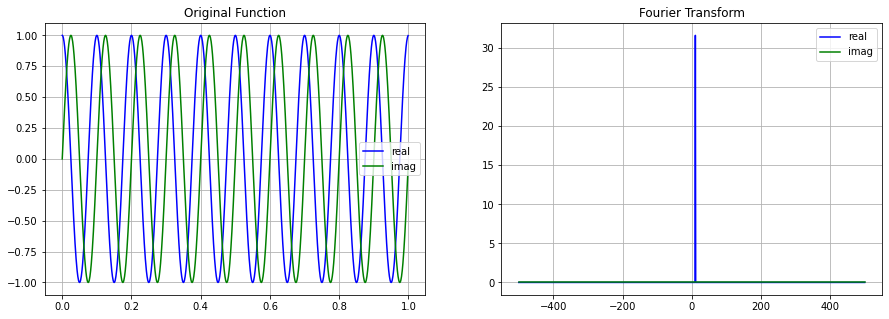

In [51]:
import numpy as np

xmin = 0.
xmax = 1.
N=1000

x = np.linspace(xmin,xmax , N, endpoint=False)
w = 10
y = np.exp(1.j * w * x *2*np.pi)# + np.exp(1.j * 3 * x * 2*np.pi)

out = FFT(y,x,opts={"plot":True})

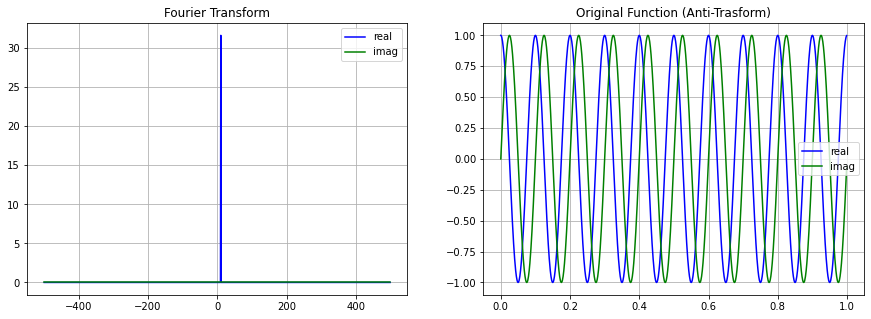

In [54]:
#inv = np.asarray(out["fft"])
#xinv = np.asarray(out.index)
orig = FFT(out["fft"],x,opts={"plot":True,"inv":True})